<a href="https://colab.research.google.com/github/wdoppenberg/mp-operational-envelope/blob/master/OperationalEnvelope.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Current operational envelope

[Source](https://pdfs.semanticscholar.org/3407/0d83c8b6c77a0f95a16c444f4460dfe5e58c.pdf) 


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [0]:
def mdot(p, A_t, Gamma, R, T_c):
    """
    Mass flow function.

    Accepts type `np.array` for `p` and `T_c`
    """
    return (p*A_t*Gamma) / np.sqrt(R*T_c)

def p_t(V_0, p_0, m_exit_t, rho):
    """
    Pressure vs time function.
    """
    return (V_0 * p_0) / (V_0 + (m_exit_t/rho))

## Constant chamber temperature


### Constants

In [0]:
# Time & timestep
dt = 0.1      #s
t_end = 2500    #s
t = np.arange(0, t_end, dt, dtype='f')

# Propellant properties
h = 2256e3      #J/kg
c_l = 4187      #J/K/kg liquid water
c_v = 1996      #J/K/kg water vapour
Gamma = 0.6712
R = 461.67      #J/K/kg
rho = 997       #kg/m^3
p_vap0 = 1e5
T_vap0 = 373
h_vap = 40e3
R_vap = 8.341

# Geometric & environmental properties
A_t = 4.5e-9    #m^2 
l = 0.30        #m
d = 1.57e-3     #m
T_0 = 283       #K
V_tube = (l*np.pi*(d**2))/4

### Simulate envelope

In [0]:
p_0 = np.arange(1., 2.2, 0.4)*1e5
T_c0 = h_vap*T_vap0/(T_vap0*R_vap*np.log(p_vap0/p_0)+h_vap)
m_0 = p_0*A_t*Gamma/(np.sqrt(R*T_c0))
V_0 = np.arange(0.05, 0.2, 0.05)*V_tube

sim_dim = (len(p_0), len(V_0), len(t))

m = np.zeros(sim_dim)
p = np.zeros(sim_dim)
temp = np.zeros(sim_dim)

m[:, :, 0], _ = np.meshgrid(m_0, V_0, indexing='ij')
p[:, :, 0], V_0 = np.meshgrid(p_0, V_0, indexing='ij')
p_0 = p[:, :, 0]

T_c = 600

for ii, _ in enumerate(t[1:], 1):
    p[:,:,ii] = V_0*p_0/(V_0+temp[:,:,ii-1])
    m[:,:,ii] = mdot(p[:,:,ii-1], A_t, Gamma, R, T_c)
    temp[:,:,ii] = temp[:,:,ii-1]+m[:,:,ii]*dt/rho

T_vap = h_vap*T_vap0/(T_vap0*R_vap*np.log(p_vap0/p)+h_vap)

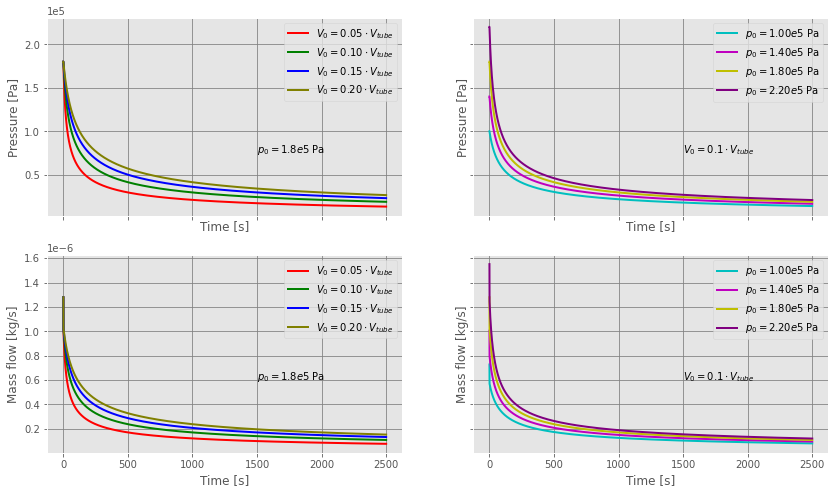

In [19]:
color = {
    'p_0': ['c', 'm', 'y', 'purple'],
    'V_0': ['r', 'g', 'b', 'olive']
}
plt.style.use('ggplot')

fig, ax = plt.subplots(2, 2, figsize=(14,8), sharex=True, sharey='row')

for i, p_i in enumerate(p[2,:,:]):
    ax[0, 0].plot(
        t, 
        p_i, 
        label=f'$V_0 = {V_0[0,i]/V_tube:.2f}\cdot V_{{tube}}$',
        color=color['V_0'][i],
        linewidth=2
    )

ax[0, 0].set_xlabel('Time [s]')
ax[0, 0].set_ylabel('Pressure [Pa]')
ax[0, 0].text(1500, 0.75e5, f'$p_0 = {p[2,0,0]/1e5:.1f}e5$ Pa')
ax[0, 0].ticklabel_format(axis="y", style="sci")
ax[0, 0].legend()
ax[0, 0].grid(color='grey')

for i, p_i in enumerate(p[:,1,:]):
    ax[0, 1].plot(
        t,
        p_i,
        label=f'$p_0 = {p[i,0,0]/1e5:.2f}e5$ Pa',
        color=color['p_0'][i],
        linewidth=2
    )

ax[0, 1].set_xlabel('Time [s]')
ax[0, 1].set_ylabel('Pressure [Pa]')
ax[0, 1].text(1500, 0.75e5, f'$V_0 = {V_0[1,1]/V_tube}\cdot V_{{tube}}$')
ax[0, 1].ticklabel_format(axis="y", style="sci")
ax[0, 1].legend()
ax[0, 1].grid(color='grey')

for i, p_i in enumerate(m[2,:,:]):
    ax[1, 0].plot(
        t,
        p_i,
        label=f'$V_0 = {V_0[0,i]/V_tube:.2f}\cdot V_{{tube}}$',
        color=color['V_0'][i],
        linewidth=2
    )

ax[1, 0].set_xlabel('Time [s]')
ax[1, 0].set_ylabel('Mass flow [kg/s]')
ax[1, 0].text(1500, 0.6e-6, f'$p_0 = {p[2,0,0]/1e5:.1f}e5$ Pa')
ax[1, 0].legend()
ax[1, 0].grid(color='grey')

for i, p_i in enumerate(m[:,1,:]):
    ax[1, 1].plot(
        t,
        p_i,
        label=f'$p_0 = {p[i,0,0]/1e5:.2f}e5$ Pa',
        color=color['p_0'][i],
        linewidth=2
    )

ax[1, 1].set_xlabel('Time [s]')
ax[1, 1].set_ylabel('Mass flow [kg/s]')
ax[1, 1].text(1500, 0.6e-6, f'$V_0 = {V_0[1,1]/V_tube}\cdot V_{{tube}}$')
ax[1, 1].legend()
ax[1, 1].grid(color='grey')

## Final operational envelope

In [0]:
dt = 0.1        #s
t_end = 1200    #s
t = np.arange(0, t_end, dt, dtype='f')

In [0]:
p_0 = 1.1e5
T_c0 = h_vap*T_vap0/(T_vap0*R_vap*np.log(p_vap0/p_0)+h_vap)
m_0 = p_0*A_t*Gamma/(np.sqrt(R*T_c0))
V_0 = 0.12*V_tube

sim_dim = t.shape

m = np.zeros(sim_dim)
p = np.zeros(sim_dim)
T_c = np.zeros(sim_dim)

m[0] = m_0
p[0] = p_0
T_c[0] = T_c0
temp = 0

for ii, _ in enumerate(t[1:], 1):
    p[ii] = V_0*p_0/(V_0+temp)
    m[ii] = mdot(p[ii-1], A_t, Gamma, R, T_c[ii-1])
    T_c[ii] = h_vap*T_vap0/(T_vap0*R_vap*np.log(p_vap0/p[ii-1])+h_vap)
    temp = temp+m[ii-1]*dt/rho

T_vap = h_vap*T_vap0/(T_vap0*R_vap*np.log(p_vap0/p)+h_vap)
Q = m * (T_c-T_0)*c_l + h*m
V_t = V_0 * (p_0 / p)
mass = (V_tube - V_t) * rho

I_sp = 74
g_0 = 9.81
F_t = m*I_sp*g_0

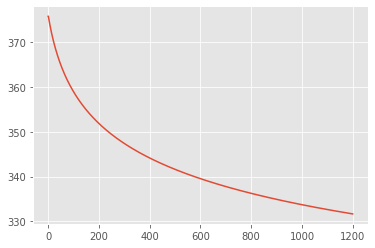

In [61]:
plt.plot(t, T_c)

## Low Reynolds number effects

* [Experimental and Numerical Determination of Micropropulsion
Device Efficiencies at Low Reynolds Numbers](https://engineering.purdue.edu/~alexeenk/papers/aiaaj-05.pdf)
* [Experimental Study of Low
Reynolds Number Nozzles ](https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19870010950.pdf)

The above operational envelope calculations do not take into account the boundary layer separation impact caused by low Reynolds numbers which often occur in microthrusters. 

$$Re = \frac{\rho u D}{\mu}$$
$$\mu = \left( \mu_{\text{ref}} \frac{T_0}{T_{\text{ref}}}\frac{2}{\gamma +1} \right)^{\omega}$$


In [0]:
D_t = np.sqrt((4/np.pi)*A_t)